### todo:
- add water masking using WOs
    - https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/DEA_products/DEA_Fractional_Cover.ipynb
- refine cloud and shadow masking for landsat sensors
- try adding landsat 7 to see what happens
- test in cloudy area
- test in area pre landsat-8

In [1]:
%pip uninstall fc -y


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install git+https://github.com/GeoscienceAustralia/fc.git -q


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import yaml
import json
import warnings
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import calendar
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from datacube.drivers.netcdf import write_dataset_to_netcdf
from fc.fractional_cover import (
    fractional_cover,
)  # import the FC package after installing it above

from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
from odc.algo import keep_good_only
from odc.algo._percentile import xr_quantile_bands
from datacube.model import Measurement
from datacube.utils import unsqueeze_dataset, masking

import sys

sys.path.insert(1, "/home/jovyan/dev/Tools/")
from dea_tools.datahandling import load_ard, wofs_fuser
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb

warnings.filterwarnings("ignore")


In [ ]:
client = create_local_dask_cluster(return_client=True)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 228.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39145,Workers: 1
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 228.00 GiB
Comm: tcp://127.0.0.1:41743,Total threads: 31
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/36947/status,Memory: 228.00 GiB
Nanny: tcp://127.0.0.1:33579,


In [ ]:
# save outputs

output_dir = "/home/jovyan/gdata1/projects/fc-sub-annual/results/tiles/"


In [ ]:
def run_fc_multi(nbart: xr.Dataset, measurements, regression_coefficients):
    results = []
    times = nbart.time.values
    for t in times:
        # Select one time slice and remove the time dimension
        input_tile = nbart.sel(time=t)
        if "time" in input_tile.dims:
            input_tile = input_tile.squeeze("time").drop("time")
        data = fractional_cover(input_tile, measurements, regression_coefficients)
        # Add time back in
        output_tile = unsqueeze_dataset(data, "time", t)
        results.append(output_tile)
    # Concatenate along time
    combined = xr.concat(results, dim="time")
    return combined


In [ ]:
MEASUREMENTS = [
    {
        "name": "BS",
        "src_var": "BS",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Bare ground fraction percentage",
            "comment": "Fraction of bare ground including rock, bare and disturbed soil, within the Landsat pixel as percentages",
            "alias": "bare",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["bare"],
    },
    {
        "name": "PV",
        "src_var": "PV",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Green cover fraction percentage",
            "comment": "Fraction of green cover including green groundcover and green leaf material over all strata, within the Landsat pixel, as percentages",
            "alias": "green",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["green_veg"],
    },
    {
        "name": "NPV",
        "src_var": "NPV",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Non-green cover fraction percentage",
            "comment": "Fraction of non green cover including litter, dead leaf and branches over all strata, within the Landsat pixel, as percentages",
            "alias": "dead",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["dead_veg"],
    },
    {
        "name": "UE",
        "src_var": "UE",
        "units": "1",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Unmixing error",
            "comment": "Euclidean Norm of the Residual Vector",
            "alias": "err",
            "coverage_content_type": "qualityInformation",
        },
        "aliases": ["err"],
    },
]


In [ ]:
"""
You need to convert your MEASUREMENTS list of dicts into a list of objects that have a .name attribute.
If you want a quick fix, you can use a namedtuple:
"""

MEASUREMENTS_OBJ = [Measurement(**m) for m in MEASUREMENTS]


In [ ]:
LANDSAT_SENSOR_REGRESSION_COEFFICIENTS = {
    "blue": [0.00041, 0.97470],
    "green": [0.00289, 0.99779],
    "red": [0.00274, 1.00446],
    "nir": [0.00004, 0.98906],
    "swir1": [0.00256, 0.99467],
    "swir2": [-0.00327, 1.02551],
}

# SENTINEL_SENSOR_REGRESSION_COEFFICIENTS = {
#     "blue": [-22.0, 0.9551],
#     "green": [31.0, 1.0582],
#     "red": [64.0, 0.9871],
#     "nir": [120.0, 1.0187],
#     "swir1": [79.0, 0.9528],
#     "swir2": [-42.0, 0.9688],
# }


In [ ]:
LANDSAT_BAND_MAPPING = (
    {"load_bands": ("green", "red", "nir", "swir1", "swir2"), "rename": None},
    {
        "load_bands": (
            "nbart_green",
            "nbart_red",
            "nbart_nir",
            "nbart_swir_1",
            "nbart_swir_2",
        ),
        "rename": {
            "nbart_green": "green",
            "nbart_red": "red",
            "nbart_nir": "nir",
            "nbart_swir_1": "swir1",
            "nbart_swir_2": "swir2",
        },
    },
)


In [ ]:
SENTINEL_BAND_MAPPING = (
    {"load_bands": ("green", "red", "nir", "swir1", "swir2"), "rename": None},
    {
        "load_bands": (
            "nbart_green",
            "nbart_red",
            "nbart_nir_1",
            "nbart_swir_2",
            "nbart_swir_3",
        ),
        "rename": {
            "nbart_green": "green",
            "nbart_red": "red",
            "nbart_nir_1": "nir",
            "nbart_swir_2": "swir1",
            "nbart_swir_3": "swir2",
        },
    },
)


In [ ]:
# region_code = ['x176y085'] #marysville
# region_code = ['x168y092'] #hopetoun
# region_code = ['x140y138'] #west macdonnell
# region_codes = ['x148y166'] #limmen NT - cloud heavy area
# region_codes = ['x175y066'] # Tas SW nat park


region_codes = ["x140y138"]

# including DEC previous year to get full season for DJF
start_date = "2024-03-01"
end_date = "2024-06-01"
time = (start_date, end_date)

ls_measurements = [
    "nbart_green",
    "nbart_red",
    "nbart_blue",
    "nbart_nir",
    "nbart_swir_1",
    "nbart_swir_2",
]

s2_measurements = [
    "nbart_green",
    "nbart_red",
    "nbart_blue",
    "nbart_nir_1",
    "nbart_swir_2",  # closest match to landsat swir1
    "nbart_swir_3",  # closest match to landsat swir2
]
# dask_chunks = dict(x=1024, y=1024, time=1)


In [ ]:
# open tiles and select

gdf = gpd.read_file(
    "~/gdata1/projects/fc-sub-annual/data/testing_minitile_suite.geojson"
)

gdf = gdf[gdf["region_code"].isin(region_codes)]

geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)


In [ ]:
dc = datacube.Datacube(app="fc_ls_test")

query = {
    "time": time,
    "geopolygon": geom,
    "dask_chunks": {},
    "group_by": "solar_day",
    "output_crs": "EPSG:3577",
}


In [ ]:
# gdf.explore(
#     tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#     attr='Esri',
#     name='Esri satellite'
# )


In [ ]:
ls_ds = load_ard(
    dc=dc,
    products=["ga_ls8c_ard_3", "ga_ls9c_ard_3"],
    measurements=ls_measurements,
    resolution=(-30, 30),
    cloud_mask="fmask",
    mask_pixel_quality=True,
    fmask_categories=["valid", "snow", "water"],
    mask_filters=[("dilation", 5)],
    mask_contiguity=True,
    skip_broken_datasets=True,
    verbose=True,
    **query,
)


Finding datasets
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Applying morphological filters to pixel quality mask: [('dilation', 5)]
Applying fmask pixel quality/cloud mask
Applying contiguity mask (oa_nbart_contiguity)
Returning 12 time steps as a dask array


In [ ]:
s2_ds = load_ard(
    dc=dc,
    products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    measurements=s2_measurements,
    resolution=(-30, 30),
    cloud_mask="s2cloudless",
    mask_pixel_quality=True,
    mask_contiguity=True,
    skip_broken_datasets=True,
    verbose=True,
    **query,
)


Finding datasets
    ga_s2am_ard_3


    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Applying contiguity mask (oa_nbart_contiguity)
Returning 19 time steps as a dask array


In [ ]:
for mapping in LANDSAT_BAND_MAPPING:
    if mapping["rename"]:
        ls_rename_dict = mapping["rename"]
        break

for mapping in SENTINEL_BAND_MAPPING:
    if mapping["rename"]:
        s2_rename_dict = mapping["rename"]
        break

ls_renamed = ls_ds.rename(ls_rename_dict)

s2_renamed = s2_ds.rename(s2_rename_dict)


In [ ]:
ls_fc = run_fc_multi(
    ls_renamed, MEASUREMENTS_OBJ, LANDSAT_SENSOR_REGRESSION_COEFFICIENTS
)


In [ ]:
s2_fc = run_fc_multi(
    s2_renamed, MEASUREMENTS_OBJ, LANDSAT_SENSOR_REGRESSION_COEFFICIENTS
)


In [ ]:
for coord in ls_ds.coords:
    if coord not in ls_fc.coords:
        ls_fc = ls_fc.assign_coords({coord: ls_ds.coords[coord]})
ls_fc.attrs = ls_ds.attrs.copy()

merged_ls = xr.merge([ls_ds, ls_fc])


In [ ]:
for coord in s2_ds.coords:
    if coord not in s2_fc.coords:
        s2_fc = s2_fc.assign_coords({coord: s2_ds.coords[coord]})
s2_fc.attrs = s2_ds.attrs.copy()

merged_s2 = xr.merge([s2_ds, s2_fc])


## merge sensors

In [ ]:
# both Landsat and Sentinel-2 FC datasets merged here.
# NOTE: This is probably not done correctly and is for demo purposes/ Jenna learning only

merged_all = xr.concat([merged_ls, merged_s2], dim="time")
merged_all = merged_all.drop_vars(
    ["nbart_nir", "nbart_nir_1", "nbart_swir_1", "nbart_swir_2", "nbart_swir_3"]
)  # drop duplicate NIR band from S2

merged_all


<xarray.Dataset> Size: 565MB
Dimensions:      (time: 31, y: 1067, x: 1067)
Coordinates:
  * time         (time) datetime64[ns] 248B 2024-03-03T01:07:37.279159 ... 20...
  * y            (y) float64 9kB -2.464e+06 -2.464e+06 ... -2.496e+06 -2.496e+06
  * x            (x) float64 9kB 6.4e+04 6.404e+04 ... 9.596e+04 9.598e+04
    spatial_ref  int32 4B 3577
Data variables:
    nbart_green  (time, y, x) float32 141MB dask.array<chunksize=(1, 1067, 1067), meta=np.ndarray>
    nbart_red    (time, y, x) float32 141MB dask.array<chunksize=(1, 1067, 1067), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 141MB dask.array<chunksize=(1, 1067, 1067), meta=np.ndarray>
    BS           (time, y, x) int8 35MB dask.array<chunksize=(1, 1067, 1067), meta=np.ndarray>
    PV           (time, y, x) int8 35MB dask.array<chunksize=(1, 1067, 1067), meta=np.ndarray>
    NPV          (time, y, x) int8 35MB dask.array<chunksize=(1, 1067, 1067), meta=np.ndarray>
    UE           (time, y, x) int8 35MB dask.array<chunksize=(1, 1067, 1067), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## calculating percentiles

In [ ]:
merged_all = masking.mask_invalid_data(merged_all)
ls_fc = masking.mask_invalid_data(ls_fc)
s2_fc = masking.mask_invalid_data(s2_fc)


In [ ]:
# mask water

wo_ls = dc.load(
    product="ga_ls_wo_3",
    group_by="solar_day",
    fuse_func=wofs_fuser,
    like=ls_ds,
)

wo_s2 = dc.load(
    product="ga_s2_wo_provisional_3",
    fuse_func=wofs_fuser,
    group_by="solar_day",
    like=s2_ds,
)


In [ ]:
wo_merged = xr.concat([wo_ls, wo_s2], dim="time")

wo_merged


<xarray.Dataset> Size: 32MB
Dimensions:      (time: 28, y: 1067, x: 1067)
Coordinates:
  * time         (time) datetime64[ns] 224B 2024-03-03T01:07:37.279159 ... 20...
  * y            (y) float64 9kB -2.464e+06 -2.464e+06 ... -2.496e+06 -2.496e+06
  * x            (x) float64 9kB 6.4e+04 6.404e+04 ... 9.596e+04 9.598e+04
    spatial_ref  int32 4B 3577
Data variables:
    water        (time, y, x) uint8 32MB 64 64 64 64 64 64 64 ... 0 0 0 0 0 0 0
Attributes:
    crs:           PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["G...
    grid_mapping:  spatial_ref

In [ ]:
wo_mask = masking.make_mask(wo_merged.water, dry=True)


In [ ]:
fc_merged_wo_masked = merged_all.where(wo_mask)
fc_ls_wo_masked = ls_fc.where(wo_mask)
fc_s2_wo_masked = s2_fc.where(wo_mask)


In [ ]:
stacked_pc = xr_quantile_bands(
    fc_merged_wo_masked, quantiles=[0.1, 0.5, 0.9], nodata=np.nan
)
ls_pc = xr_quantile_bands(fc_ls_wo_masked, quantiles=[0.1, 0.5, 0.9], nodata=np.nan)
s2_pc = xr_quantile_bands(fc_s2_wo_masked, quantiles=[0.1, 0.5, 0.9], nodata=np.nan)


## Means, Medians and rolling medians oh my...

In [ ]:
def save_as_netcdf(ds, ds_name):
    """
    Save the dataset to a NetCDF file."""

    output_path = os.path.join(
        output_dir, f"{ds_name}_{start_date}-{end_date}_{region_codes[0]}.nc"
    )

    if os.path.exists(output_path):
        os.remove(output_path)
        print(f"Removed existing file: {output_path}")

    write_dataset_to_netcdf(ds, os.path.join(output_path))


In [ ]:
monthly_medians = fc_merged_wo_masked.groupby("time.month").median(
    dim="time", keep_attrs=True
)

monthly_counts = fc_merged_wo_masked["BS"].groupby("time.month").count(dim="time")
monthly_medians["obs_count"] = monthly_counts

save_as_netcdf(monthly_medians, "monthly_fc_blended_medians_")

monthly_medians


/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [ ]:
seasonal_medians = fc_merged_wo_masked.groupby("time.season").median(
    dim="time", keep_attrs=True
)

seasonal_counts = fc_merged_wo_masked["BS"].groupby("time.season").count(dim="time")
seasonal_medians["obs_count"] = seasonal_counts

save_as_netcdf(seasonal_medians, "seasonal_fc_blended_medians_")


In [ ]:
monthly_medians.compute()


/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


<xarray.Dataset> Size: 10MB
Dimensions:      (month: 6, y: 214, x: 214)
Coordinates:
  * y            (y) float64 2kB -2.464e+06 -2.464e+06 ... -2.496e+06 -2.496e+06
  * x            (x) float64 2kB 6.398e+04 6.412e+04 ... 9.578e+04 9.592e+04
    spatial_ref  int32 4B 3577
  * month        (month) int64 48B 3 4 5 6 7 8
Data variables:
    nbart_green  (month, y, x) float32 1MB 803.0 797.0 797.0 ... 866.0 868.5
    nbart_red    (month, y, x) float32 1MB 1.534e+03 1.493e+03 ... 1.468e+03
    nbart_blue   (month, y, x) float32 1MB 503.0 505.0 505.0 ... 550.0 544.0
    BS           (month, y, x) float32 1MB 41.0 41.0 41.0 ... 35.5 38.0 35.5
    PV           (month, y, x) float32 1MB 10.0 9.0 9.0 9.0 ... 19.5 18.0 20.0
    NPV          (month, y, x) float32 1MB 49.0 52.0 51.0 ... 43.0 42.0 42.0
    UE           (month, y, x) float32 1MB 9.0 10.0 10.0 10.0 ... 9.0 9.0 9.5
    obs_count    (month, y, x) int64 2MB 3 3 3 3 3 3 3 3 ... 9 10 10 10 10 10 10
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

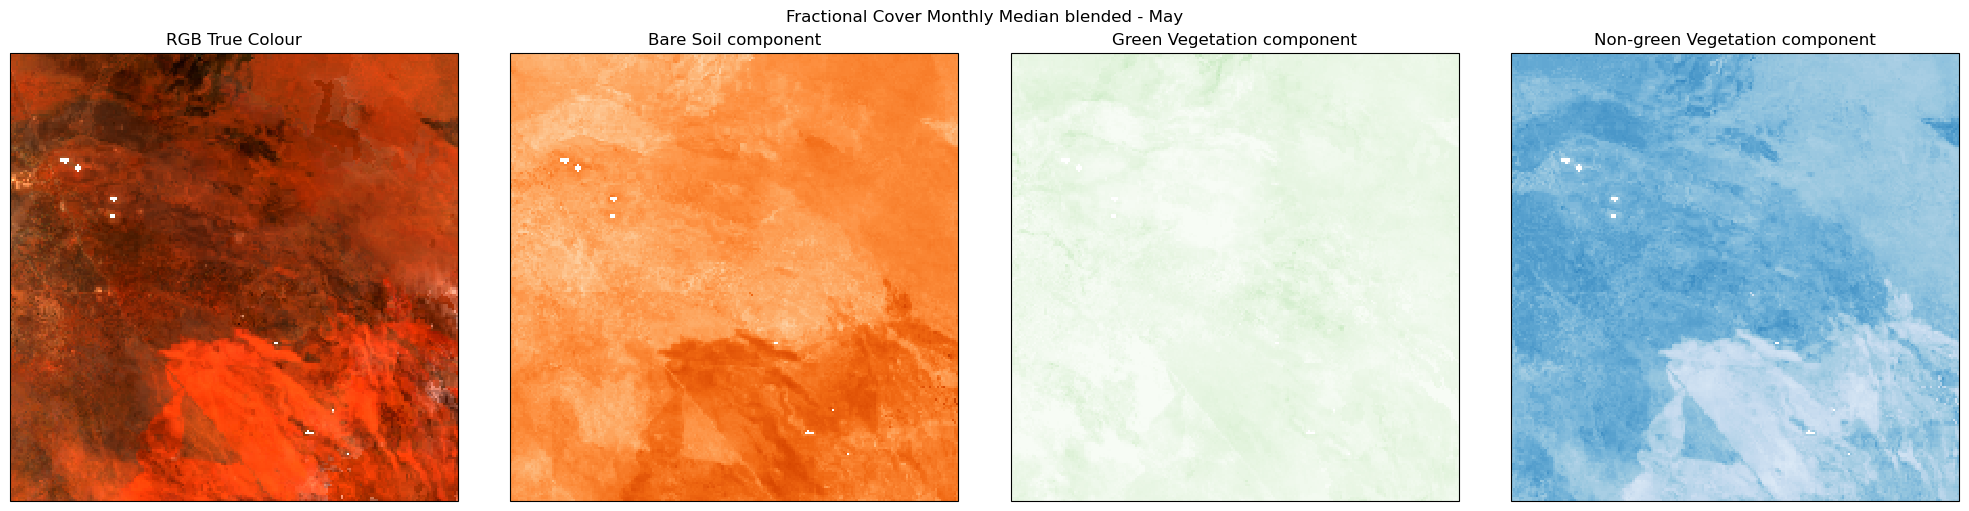

In [ ]:
n_steps = 1

fig, axs = plt.subplots(
    1,
    4,
    figsize=(20, 5),
    layout="constrained",
    subplot_kw={"projection": ccrs.epsg(3577)},
)

for step in range(n_steps):
    month_number = monthly_medians["month"].values[i]
    month_name = calendar.month_name[month_number]

    rgb_true = xr.concat(
        [
            monthly_medians["nbart_red"].isel(month=step),
            monthly_medians["nbart_green"].isel(month=step),
            monthly_medians["nbart_blue"].isel(month=step),
        ],
        dim="band",
    )
    rgb_true = rgb_true.persist()
    rgb_true.plot.imshow(ax=axs[0], robust=True, transform=ccrs.epsg(3577))
    axs[0].set_title("RGB True Colour")

    monthly_medians["BS"].isel(month=step).plot.imshow(
        ax=axs[1],
        cmap="Oranges",
        vmin=0,
        vmax=100,
        add_colorbar=False,
        transform=ccrs.epsg(3577),
    )
    axs[1].set_title("Bare Soil component")

    monthly_medians["PV"].isel(month=step).plot.imshow(
        ax=axs[2],
        cmap="Greens",
        vmin=0,
        vmax=100,
        add_colorbar=False,
        transform=ccrs.epsg(3577),
    )
    axs[2].set_title("Green Vegetation component")

    monthly_medians["NPV"].isel(month=step).plot.imshow(
        ax=axs[3],
        cmap="Blues",
        vmin=0,
        vmax=100,
        add_colorbar=False,
        transform=ccrs.epsg(3577),
    )
    axs[3].set_title("Non-green Vegetation component")

    for ax in axs:
        ratio = 1.0
        x_left, x_right = ax.get_xlim()
        y_low, y_high = ax.get_ylim()
        ax.set_aspect(abs((x_right - x_left) / (y_low - y_high)) * ratio)

    plt.suptitle(
        f"Fractional Cover Monthly Median blended - {region_codes[0]} - {month_name}"
    )
    plt.savefig(
        os.path.join(
            output_dir, f"fc_monthly_median_{region_codes[0]}_{month_name}.png"
        ),
        bbox_inches="tight",
        dpi=300,
    )
    plt.close()


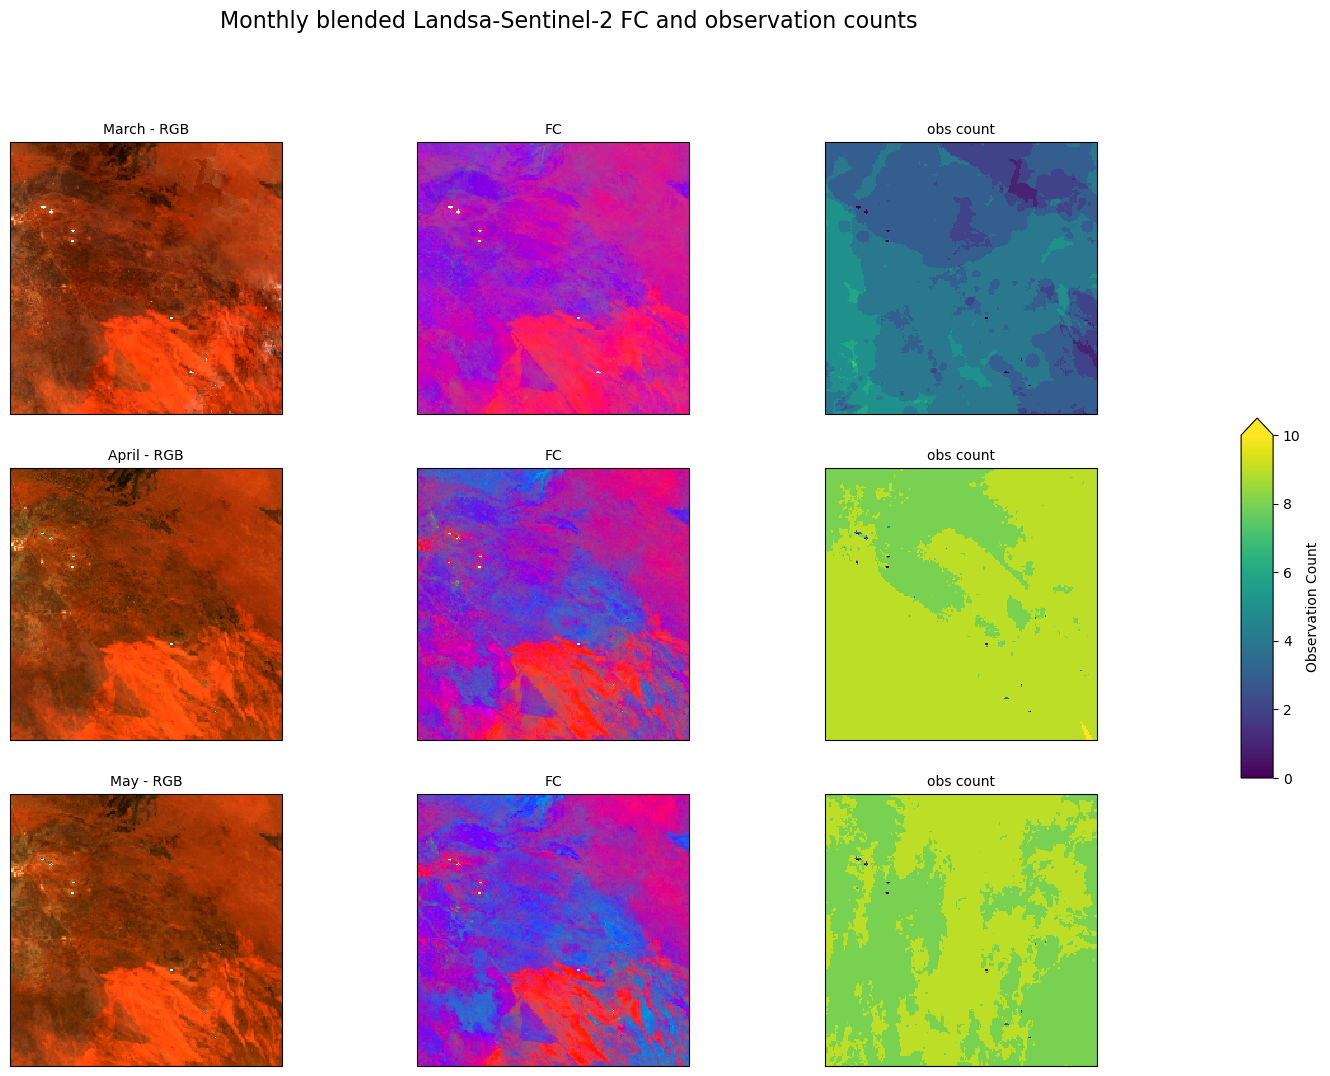

CPU times: user 14.2 s, sys: 1.28 s, total: 15.5 s
Wall time: 3min 42s


In [ ]:
%%time

#n_steps = monthly_medians.sizes["month"]
n_steps=3

bounds = np.arrage(0,10, 1)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)
cmap = plt.get_cmap('gnuplot', len(bounds)- 1)

vmin = 0
vmax = 10

# Use gridspec to add an extra column for the colorbar
fig = plt.figure(figsize=(4 * 3.5, 4 * n_steps))
gs = gridspec.GridSpec(nrows=n_steps, ncols=4, width_ratios=[1, 1, 1, 0.05])

axs = np.empty((n_steps, 3), dtype=object)
for i in range(n_steps):
    for j in range(3):
        axs[i, j] = fig.add_subplot(gs[i, j], projection=ccrs.epsg(3577))


for i in range(n_steps):
    # get calendar month name for plotting
    month_number = monthly_medians['month'].values[i]
    month_name = calendar.month_name[month_number]
    
    # True Colour RGB
    rgb_true = (
        xr.concat(
            [
                monthly_medians["nbart_red"].isel(month=i),
                monthly_medians["nbart_green"].isel(month=i),
                monthly_medians["nbart_blue"].isel(month=i),
            ],
            dim="band",
        )
        / 3000
    )
    #rgb_true = rgb_true.persist()
    rgb_true.plot.imshow(ax=axs[i, 0], robust=True, transform=ccrs.epsg(3577))
    axs[i, 0].set_title(f"{month_name} - RGB", fontsize=10)

    # FC RGB
    rgb_fc = (
        xr.concat(
            [
                monthly_medians["BS"].isel(month=i),
                monthly_medians["PV"].isel(month=i),
                monthly_medians["NPV"].isel(month=i),
            ],
            dim="band",
        )
        / 100
    )
    # rgb_fc = rgb_fc.persist()
    rgb_fc.plot.imshow(ax=axs[i, 1], robust=True, add_colorbar=False, transform=ccrs.epsg(3577))
    axs[i, 1].set_title(f"FC", fontsize=10)
    
    
    # Observation count
    obs_count = monthly_medians["obs_count"].isel(month=i)
    # obs_count = obs_count.persist()
    im = obs_count.plot.imshow(
        ax=axs[i, 2], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.epsg(3577)
    )
    axs[i, 2].set_title(f"obs count", fontsize=10)
    

cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax, extend='max', plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label("Observation Count")

fig.suptitle("Monthly blended Landsa-Sentinel-2 FC and observation counts", fontsize=16, y=0.99)

plt.show()


ValueError: Dimensions {'month'} do not exist. Expected one or more of ('season', 'y', 'x')

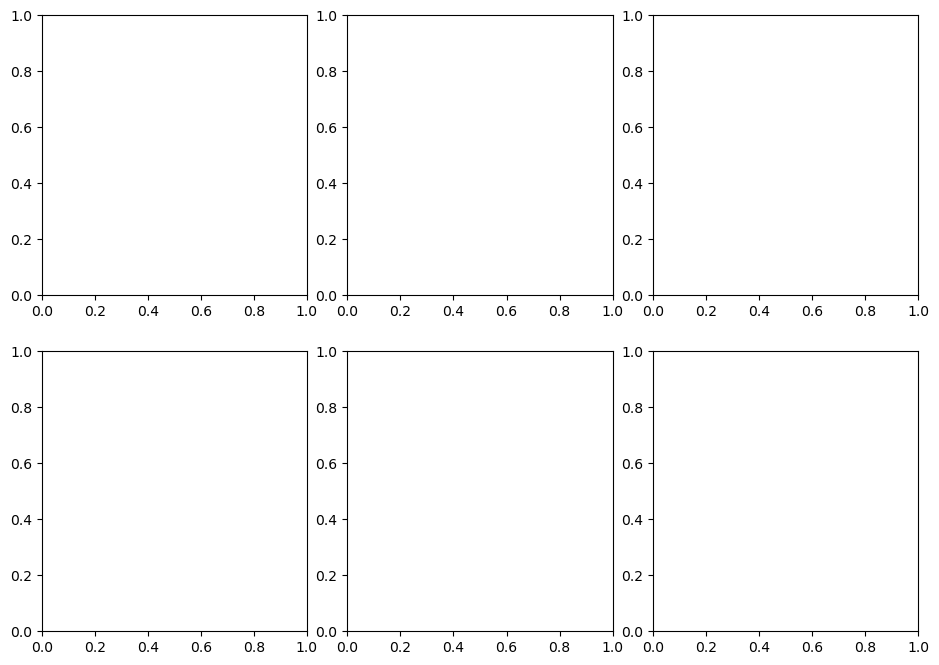

In [ ]:
%%time

n_steps = seasonal_medians.sizes["season"]

# Use gridspec to add an extra column for the colorbar
fig = plt.figure(figsize=(4 * 3, 4 * n_steps))
gs = gridspec.GridSpec(nrows=n_steps, ncols=4, width_ratios=[1, 1, 1, 0.05])

axs = np.empty((n_steps, 3), dtype=object)
for i in range(n_steps):
    for j in range(3):
        axs[i, j] = fig.add_subplot(gs[i, j])

cmap = "viridis"
vmin = 0
vmax = 10

for i in range(n_steps):
    # get calendar month name for plotting
    season_label = seasonal_medians['season'].values[i]
    
    # True Colour RGB
    rgb_true = (
        xr.concat(
            [
                seasonal_medians["nbart_red"].isel(month=i),
                seasonal_medians["nbart_green"].isel(month=i),
                seasonal_medians["nbart_blue"].isel(month=i),
            ],
            dim="band",
        )
        / 3000
    )
    # rgb_true = rgb_true.persist()
    rgb_true.plot.imshow(ax=axs[i, 0], robust=True, add_colorbar=False)
    axs[i, 0].set_title(f"{season_label}", fontsize=10)
    axs[i, 0].axis("off")

    # FC RGB
    rgb_fc = (
        xr.concat(
            [
                seasonal_medians["BS"].isel(month=i),
                seasonal_medians["PV"].isel(month=i),
                seasonal_medians["NPV"].isel(month=i),
            ],
            dim="band",
        )
        / 100
    )
    # rgb_fc = rgb_fc.persist()
    rgb_fc.plot.imshow(ax=axs[i, 1], robust=True, add_colorbar=False)
    axs[i, 1].set_title(" ")
    axs[i, 1].axis("off")

    # Observation count
    obs_count = seasonal_medians["obs_count"].isel(month=i)
    # obs_count = obs_count.persist()
    im = obs_count.plot.imshow(
        ax=axs[i, 2], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False
    )
    axs[i, 2].set_title(f" ")
    axs[i, 2].axis("off")

# Add a single colorbar to the right
#cax = fig.add_subplot(gs[:, 3])
#cbar = fig.colorbar(im, cax=cax, fraction = 0.05, pad =0.07, shrink=0.4)

cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax, extend='max')
cbar.set_label("Observation Count")

fig.text(0.15, 0.95, "RGB median", ha='center', va='center', fontsize=12)
fig.text(0.45, 0.95, "FC RGB", ha='center', va='center', fontsize=12)
fig.text(0.70, 0.95, "Obs Count", ha='center', va='center', fontsize=12)

fig.suptitle("Monthly blended Landsa-Sentinel-2 FC and observation counts", fontsize=16, y=0.99)

plt.show()
